In [1]:
!python --version

Python 3.10.9


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skreducedmodel.reducedbasis import ReducedBasis
from skreducedmodel.empiricalinterpolation import EmpiricalInterpolation
from skreducedmodel.reducedbasis import normalize_set, error
from skreducedmodel.surrogate import Surrogate

In [2]:
#autoreload permite que jupyter vea las modif de los script de forma automática
%load_ext autoreload
%autoreload 2

Importamos datos

In [3]:
path = "tests/waveforms/"
q_train = np.load(path+"q_train_1d-seed_eq_1.npy")
q_test = np.load(path+"q_test_1d-seed_eq_1.npy")
ts_train = np.load(path+"ts_train_1d-seed_eq_1.npy")
ts_test = np.load(path+"ts_test_1d-seed_eq_1.npy")
times = np.load(path+"times_1d-seed_eq_1.npy")
# ts_test_normalized = normalize_set(ts_test, times)

# Reduced Basis

q = [8. 0. 0.]


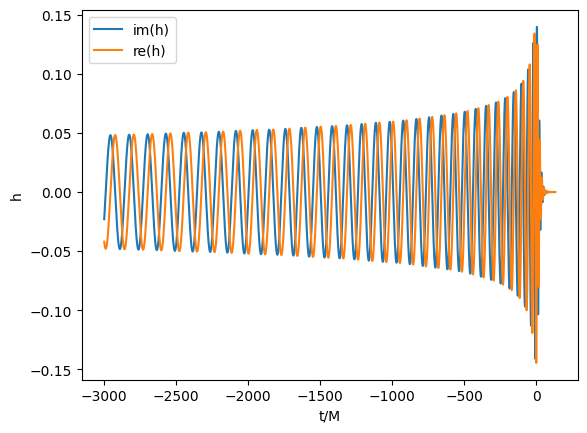

In [7]:
idx = 1
print(f"q = {q_train[idx]}")
plt.xlabel("t/M")
plt.ylabel("h")
plt.plot(times,np.imag(ts_train[idx]), label="im(h)")
plt.plot(times,np.real(ts_train[idx]), label="re(h)")
plt.legend();

Importamos la clase ReducedBasis, diseñada al estilo sci-kit y entrenamos un modelo hp-greedy.

In [9]:
rb = ReducedBasis(index_seed_global_rb = 0,
                  greedy_tol = 1e-16,
                  lmax = 2,
                  nmax = 5,
                  normalize = True,
                  integration_rule="riemann"
                  )

rb.fit(training_set = ts_train,
       parameters = q_train,
       physical_points = times
       )

Visualizamos el orden de las particiones realizadas

In [10]:
from anytree import RenderTree

def visual_tree(tree):
    for pre, fill, node in RenderTree(tree):
        print("%s%s" % (pre, node.name))

visual_tree(rb.tree)

(0,)
├── (0, 0)
│   ├── (0, 0, 0)
│   └── (0, 0, 1)
└── (0, 1)
    ├── (0, 1, 0)
    └── (0, 1, 1)


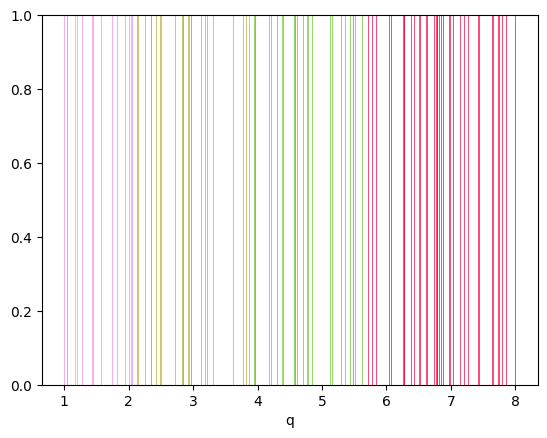

In [11]:
np.random.seed(seed=4)
plt.xlabel("q")
for leaf in rb.tree.leaves:
    color = np.random.rand(3,)
    for p in leaf.train_parameters[:,0]:
        plt.axvline(p,c=color,lw=.5)

Vemos el error en función del parámetro q

/home/fcerino/env_skrm/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


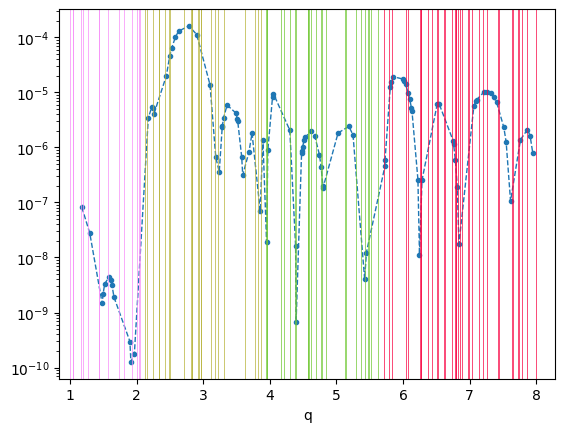

In [11]:
from skreducedmodel.reducedbasis import normalize_set, error

# normalizamos el conjunto de ondas de testeo
ts_test_normalized = normalize_set(ts_test, times)

# calculamos la proyección de las ondas con el modelo hp-greedy
hts = []
for h, q in zip(ts_test_normalized, q_test):
    hts.append(rb.transform(h,q))
hts = np.array(hts)

# calculamos el error para cada una de las proyecciones
errors = []
for i in range(ts_test_normalized.shape[0]):
    errors.append(error(ts_test_normalized[i], hts[i], times))

# graficamos la dependencia de los errores con respecto al parámetro q
plt.yscale("log")
plt.plot(np.sort(q_test[:,0]), np.array(errors)[np.argsort(q_test[:,0])], "o--", ms=3, lw=1);

np.random.seed(seed=4)
plt.xlabel("q")
for leaf in rb.tree.leaves:
    color = np.random.rand(3,)
    for p in leaf.train_parameters[:,0]:
        plt.axvline(p,c=color,lw=.5)

Ploteamos una onda proyectada vs la normal

Veamos la variación del error frente a diferentes hiperparámetros Lmax y Nmax

In [ ]:
from skreducedmodel.reducedbasis import ReducedBasis

range_lmax = range(0,5)
range_nmax = range(5,26,5)

plt.yscale("log")
plt.xlabel("nmax")
plt.ylabel("max error")


for lmax in range_lmax:
    max_errors = []
    for nmax in range_nmax:
        rb = ReducedBasis(index_seed_global_rb = 0,
                          greedy_tol = 1e-16,
                          lmax = lmax,
                          nmax = nmax,
                          normalize = True,
                          integration_rule="riemann"
                          )

        rb.fit(training_set = ts_train,
               parameters = q_train,
               physical_points = times
               )

        errors = []
        for h, q in zip(ts_test_normalized, q_test):
            # calculamos la proyección de las ondas con el modelo hp-greedy
            ht = rb.transform(h,q)
            # calculamos el error para la proyección
            errors.append(error(h, ht, times))

        # tomamos el error máximo en el conjunto de validación
        max_errors.append(np.max(errors))
    plt.plot(range_nmax, max_errors, "o--", label = f"lmax = {lmax}")
plt.legend();

En el enfoque de bases reducidas, una menor dimensionalidad de la base implica representaciones con menor costo computacional para ser evaluadas.

Se puede ver que existen casos que para llegar a una precision dada, al particionar el dominio se obtienen bases con dimensionalidad menor que una global.

Por ejemplo, para llegar a representaciones con error máximo de ~ 10e(-14), con lmax = 0 (sin particion) se necesita una base de dimension ~20, mientras con lmax=2 se necesitan bases de a lo sumo dimensión 10.

Ahora probamos el mismo experimento con otra semilla:

In [ ]:
index_seed_global_rb = -1

range_lmax = range(0,5)
range_nmax = range(5,26,5)

plt.yscale("log")
plt.xlabel("nmax")
plt.ylabel("max error")


for lmax in range_lmax:
    max_errors = []
    for nmax in range_nmax:
        rb = ReducedBasis(index_seed_global_rb = index_seed_global_rb,
                          greedy_tol = 1e-16,
                          lmax = lmax,
                          nmax = nmax,
                          normalize = True,
                          integration_rule="riemann"
                          )

        rb.fit(training_set = ts_train,
               parameters = q_train,
               physical_points = times
               )

        errors = []
        for h, q in zip(ts_test_normalized, q_test):
            # calculamos la proyección de las ondas con el modelo hp-greedy
            ht = rb.transform(h,q)
            # calculamos el error para la proyección
            errors.append(error(h, ht, times))

        # tomamos el error máximo en el conjunto de validación
        max_errors.append(np.max(errors))
    plt.plot(range_nmax, max_errors, "o--", label = f"lmax = {lmax}")
plt.legend();

Se puede ver que hay una dependencia de los errores con respecto a la semilla.

Por lo tanto, esta se puede tomar como un hiperparámetro "relevante" del modelo.

Se menciona como "relevante" debido a que en el caso sin partición la elección de la semilla otorga resultados que se pueden tomar como equivalentes, debido a que en estudios realizados anteriormente se muestra como esta no afecta a la capacidad de representacion de las bases resultantes, más allá de que estas pueden no ser construidas exactamente con los mismos elementos del espacio de entrenamiento.

---------

# EIM

In [9]:
# normalizamos el conjunto de ondas de testeo
ts_test_normalized = normalize_set(ts_test, times)

asi dandole una rb

In [10]:
rb = ReducedBasis(index_seed_global_rb = 0,
                  greedy_tol = 1e-16,
                  lmax = 0,
                  nmax = np.inf,
                  normalize = True,
                  integration_rule="riemann"
                  )

rb.fit(training_set = ts_train,
       parameters = q_train,
       physical_points = times
       )

eim = EmpiricalInterpolation(reduced_basis=rb)

In [11]:
eim.fit # xq sin () ??

In [13]:
eim.base.tree.leaves[0].is_leaf

True

si no le quiero dar una rb y que se resuelva automaticamente por detras:

eim_model = EmpiricalInterpolation()

o 

eim_model = EmpiricalInterpolation(
                  index_seed_global_rb = 0,
                  greedy_tol = 1e-16,
                  lmax = 2,
                  nmax = 5,
                  normalize = True,
                  integration_rule="riemann"
                  )

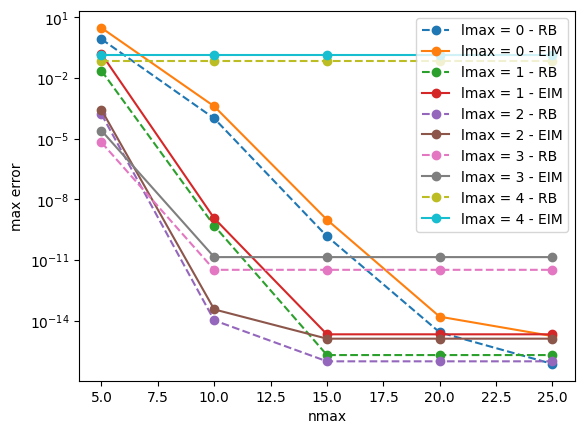

In [15]:
index_seed_global_rb = 0

range_lmax = range(0,5)
range_nmax = range(5,26,5)

plt.yscale("log")
plt.xlabel("nmax")
plt.ylabel("max error")


for lmax in range_lmax:
    max_errors_rb = []
    max_errors_eim = []

    for nmax in range_nmax:
        rb = ReducedBasis(index_seed_global_rb = index_seed_global_rb,
                          greedy_tol = 1e-16,
                          lmax = lmax,
                          nmax = nmax,
                          normalize = True,
                          integration_rule="riemann"
                          )

        rb.fit(training_set = ts_train,
               parameters = q_train,
               physical_points = times
               )
        
        eim = EmpiricalInterpolation(reduced_basis=rb)
        eim.fit()
        
        errors_rb = []
        errors_eim = []
        for h, q in zip(ts_test_normalized, q_test):
            # calculamos la proyección de las ondas con el modelo hp-greedy
            h_rb = rb.transform(h,q)
            h_eim = eim.transform(h,q)
            
            # calculamos el error para la proyección
            errors_rb.append(error(h, h_rb, times))
            errors_eim.append(error(h, h_eim, times))

        # tomamos el error máximo en el conjunto de validación
        max_errors_rb.append(np.max(errors_rb))
        max_errors_eim.append(np.max(errors_eim))
        
    plt.plot(range_nmax, max_errors_rb, "o--", label = f"lmax = {lmax} - RB")
    plt.plot(range_nmax, max_errors_eim, "o-", label = f"lmax = {lmax} - EIM")

plt.legend();

In [62]:
rb = ReducedBasis(index_seed_global_rb = 0,
                          greedy_tol = 1e-16,
                          lmax = 0,
                          nmax = np.inf,
                          normalize = True,
                          integration_rule="riemann"
                          )

rb.fit(training_set = ts_train,
       parameters = q_train,
       physical_points = times
       )

In [63]:
eim = EmpiricalInterpolation(rb, greedy_tol = 1e-10, lmax = 1)

In [66]:
"tree" in vars(eim.base)

True

In [55]:
eim.base

In [56]:
vars(eim.base)

{'index_seed_global_rb': 0,
 'lmax': 0,
 'nmax': inf,
 'greedy_tol': 1e-16,
 'normalize': True,
 'integration_rule': 'riemann',
 '_ReducedBasis__first_iteration': False,
 'tree': Node('/(0,)', basis=array([[ 7.92997522e-03+1.07442480e-02j,  7.96932812e-03+1.07152448e-02j,
          8.00857533e-03+1.06860971e-02j, ...,
          1.92993784e-06-1.92202361e-06j,  1.63683742e-06-2.00223259e-06j,
          1.34677516e-06-2.04578950e-06j],
        [ 1.35379316e-02+4.15665707e-03j,  1.35591917e-02+4.09482390e-03j,
          1.35801690e-02+4.03288438e-03j, ...,
         -4.33692882e-07+3.59039204e-07j, -4.01934867e-07+6.50271373e-07j,
         -3.67116153e-07+9.27837555e-07j],
        [-9.75306154e-04-1.16628200e-02j, -1.02526987e-03-1.16606345e-02j,
         -1.07523285e-03-1.16582356e-02j, ...,
         -2.35681089e-07-2.01163061e-07j, -6.28151341e-08-1.54239103e-07j,
          8.36777442e-08-9.06740559e-08j],
        ...,
        [ 3.30696659e-02-4.67762835e-02j,  3.26740325e-02-4.66116856e

In [57]:
eim = EmpiricalInterpolation(greedy_tol = 1e-10, lmax = 1)

In [58]:
vars(eim)

{'base': <skreducedmodel.reducedbasis.ReducedBasis at 0x7f9a55d11270>}

In [60]:
eim.base, vars(eim.base)

(<skreducedmodel.reducedbasis.ReducedBasis at 0x7f9a55d11270>,
 {'index_seed_global_rb': 0,
  'lmax': 1,
  'nmax': inf,
  'greedy_tol': 1e-10,
  'normalize': False,
  'integration_rule': 'riemann',
  '_ReducedBasis__first_iteration': True})

In [ ]:
vars(eim)

{'index_seed_global_rb': 0,
 'lmax': 1,
 'nmax': inf,
 'greedy_tol': 1e-10,
 'normalize': False,
 'integration_rule': 'riemann',
 '_ReducedBasis__first_iteration': True}

In [67]:
def function(a,b,c):
    if a == None:
        print(4)

[autoreload of skreducedmodel.empiricalinterpolation failed: Traceback (most recent call last):
  File "/home/fcerino/env_skrm/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 257, in check
    superreload(m, reload, self.old_objects)
  File "/home/fcerino/env_skrm/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 455, in superreload
    module = reload(module)
  File "/usr/lib/python3.10/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 619, in _exec
  File "<frozen importlib._bootstrap_external>", line 879, in exec_module
  File "<frozen importlib._bootstrap_external>", line 1017, in get_code
  File "<frozen importlib._bootstrap_external>", line 947, in source_to_code
  File "<frozen importlib._bootstrap>", line 241, in _call_with_frames_removed
  File "/home/fcerino/skrm/scikit-reducedmodel/skreducedmodel/empiricalinterpolation.py", line 78
    elif training_set  paramete

In [68]:
function(a=0)

TypeError: function() missing 2 required positional arguments: 'b' and 'c'

-----

In [65]:
import numpy as np
from scipy.integrate import odeint


def pend(y, t, b, λ):
    θ, ω = y
    dydt = [ω, -b * ω - λ * np.sin(θ)]

    return dydt


b = 0.2
y0 = [np.pi / 2, 0.0]

param = np.linspace(1, 5, 101)
times = np.linspace(0, 50, 1001)

training = []
for λ in param:
    sol = odeint(pend, y0, times, (b, λ))
    training.append(sol[:, 0])

training_set = np.array(training)
parameters = param
physical_points = times
nmax = 10

model = ReducedBasis(
    index_seed_global_rb=0, greedy_tol=1e-10, lmax=0, normalize=False
)

model.fit(
    training_set=training_set,
    parameters=parameters,
    physical_points=physical_points)

ti = EmpiricalInterpolation(reduced_basis=model)
ti.fit(training_set = training_set)

InputDataError: Reduced Basis is already trained. 'training_set' or 'parameters' or'physical_points' not needed

In [41]:
import numpy as np
from scipy.integrate import odeint


def pend(y, t, b, λ):
    θ, ω = y
    dydt = [ω, -b * ω - λ * np.sin(θ)]

    return dydt


b = 0.2
y0 = [np.pi / 2, 0.0]

param = np.linspace(1, 5, 101)
times = np.linspace(0, 50, 1001)

training = []
for λ in param:
    sol = odeint(pend, y0, times, (b, λ))
    training.append(sol[:, 0])

training_set = np.array(training)
parameters = param
physical_points = times
nmax = 10

model = ReducedBasis(
    index_seed_global_rb=0, greedy_tol=1e-10, lmax=0, normalize=False
)

model.fit(
    training_set=training_set,
    parameters=parameters,
    physical_points=physical_points)

ti = EmpiricalInterpolation(reduced_basis=model)
ti.fit()

In [43]:
ti = EmpiricalInterpolation(lmax=1)

In [45]:
vars(ti.base)

{'index_seed_global_rb': 0,
 'lmax': 1,
 'nmax': inf,
 'greedy_tol': 1e-12,
 'normalize': False,
 'integration_rule': 'riemann',
 '_ReducedBasis__first_iteration': True}

In [40]:
type(training_set)

numpy.ndarray

---

In [48]:
eim_model = EmpiricalInterpolation(normalize = True,
                                   lmax = 1,
                                   nmax = 2,
                                   greedy_tol = 1e-16
                                  )
vars(eim_model.base)

{'index_seed_global_rb': 0,
 'lmax': 1,
 'nmax': 2,
 'greedy_tol': 1e-16,
 'normalize': True,
 'integration_rule': 'riemann',
 '_ReducedBasis__first_iteration': True}

In [49]:
eim_model.fit(training_set=ts_train,
              parameters=q_train,
              physical_points=times)

In [50]:
eim_model.base.tree.height

1

----

In [61]:
eim_model = EmpiricalInterpolation()
eim_model.fit(training_set=ts_train,
              parameters=q_train,
              physical_points=times
             )

In [64]:
vars(eim_model.base)

{'index_seed_global_rb': 0,
 'lmax': 0,
 'nmax': inf,
 'greedy_tol': 1e-12,
 'normalize': False,
 'integration_rule': 'riemann',
 '_ReducedBasis__first_iteration': False,
 'tree': Node('/(0,)', basis=array([[ 7.92997522e-03+1.07442480e-02j,  7.96932812e-03+1.07152448e-02j,
          8.00857533e-03+1.06860971e-02j, ...,
          1.92993784e-06-1.92202361e-06j,  1.63683742e-06-2.00223259e-06j,
          1.34677516e-06-2.04578950e-06j],
        [-4.67962495e-03-1.62420816e-02j, -4.74120277e-03-1.62247585e-02j,
         -4.80271707e-03-1.62072016e-02j, ...,
         -2.41421852e-06+1.80582463e-06j, -2.20978260e-06+1.75925707e-06j,
         -2.01348132e-06+1.70090760e-06j],
        [ 9.18180060e-03+1.80283622e-02j,  9.25226856e-03+1.79928952e-02j,
          9.32260015e-03+1.79571522e-02j, ...,
         -1.31286419e-06-1.49171367e-06j, -1.24681371e-06-1.57200995e-06j,
         -1.18252264e-06-1.63287933e-06j],
        ...,
        [-5.97848141e-02+7.19683400e-02j, -5.91573465e-02+7.17780465

In [10]:
rb_model = ReducedBasis(lmax=1)
rb_model.fit(training_set = ts_train,
             parameters = q_train,
             physical_points = times
            )

# Surrogate

In [4]:
ts_train_abs = np.real(ts_train)
ts_test_abs = np.real(ts_test)

In [5]:
ts_test_abs.shape

(100, 31300)

In [16]:
from arby import ReducedOrderModel as ROM

#normalize???
f_model = ROM(training_set=ts_train_abs[np.argsort(q_train[:,0])],
              physical_points=times,
              parameter_points=np.sort(q_train[:,0]),
              poly_deg = 3
             )

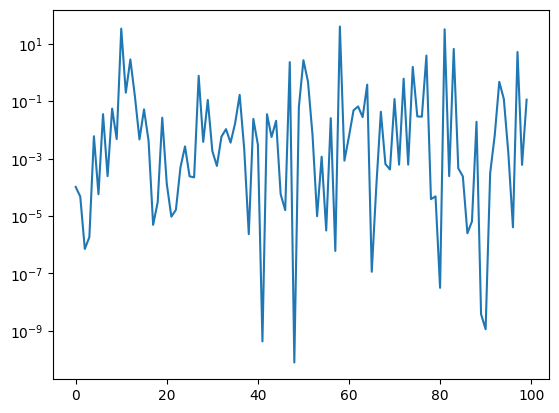

In [17]:
errors_f_model = []
for h, q in zip(ts_test_abs, q_test):
    # calculamos la proyección de las ondas con el modelo hp-greedy
    #h_rb = rom.base.transform(h,q[0])
    #h_eim = rom.eim.transform(h,q[0])
    h_rom = f_model.surrogate(q[0])

    # calculamos el error para la proyección
    #errors_rb.append(error(h, h_rb, times))
    #errors_eim.append(error(h, h_eim, times))
    errors_f_model.append(error(h, h_rom, times))

# tomamos el error máximo en el conjunto de validación
#max_errors_rb.append(np.max(errors_rb))
#max_errors_eim.append(np.max(errors_eim))
max_error_rom = np.max(errors_f_model)
plt.yscale("log")
plt.plot(errors_f_model)

In [12]:
np.max(errors_f_model)

39.63460140501361

In [13]:
del(f_model)

In [14]:
f_model

NameError: name 'f_model' is not defined

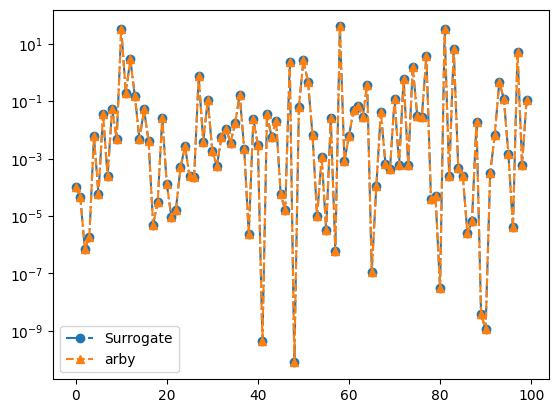

In [18]:
rom = Surrogate(lmax = 0,
                nmax = np.inf,
                normalize = False
               )
rom.fit(training_set = ts_train_abs,
              parameters = q_train[:,0],
              physical_points = times
       )

errors_rb = []
errors_eim = []
errors_rom = []
for h, q in zip(ts_test_abs, q_test):
    # calculamos la proyección de las ondas con el modelo hp-greedy
    h_rb = rom.base.transform(h,q[0])
    h_eim = rom.eim.transform(h,q[0])
    h_rom = rom.predict(q[0])

    # calculamos el error para la proyección
    errors_rb.append(error(h, h_rb, times))
    errors_eim.append(error(h, h_eim, times))
    errors_rom.append(error(h, h_rom, times))

# tomamos el error máximo en el conjunto de validación
max_errors_rb = np.max(errors_rb)
max_errors_eim = np.max(errors_eim)
max_errors_rom = np.max(errors_rom)

# tomamos el error máximo en el conjunto de validación
#max_errors_rb.append(np.max(errors_rb))
#max_errors_eim.append(np.max(errors_eim))
max_error_rom = np.max(errors_rom)
plt.yscale("log")
plt.plot(errors_rom, "o-.", label = "Surrogate")
plt.plot(errors_f_model, "^--", label = "arby")
plt.legend()

# hp-surrogate

In [9]:
rom = Surrogate(lmax=1, nmax = 20, greedy_tol = 1e-16)
rom.fit(training_set=ts_train,
              parameters=q_train[:,0],
              physical_points=times)

len(rom.base.tree.leaves)

2

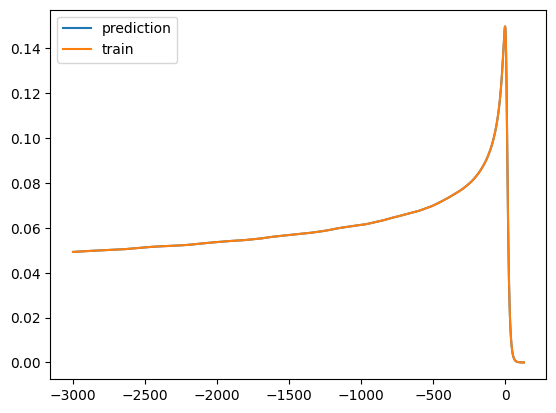

In [10]:
idx = 3
plt.plot(times, rom.predict(q_train[idx,0]), label="prediction")
plt.plot(times, ts_train[idx], label="train")
plt.legend()

NameError: name 'ts_test_normalized' is not defined

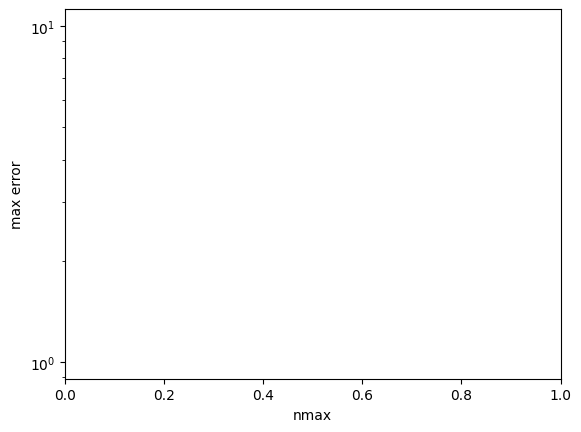

In [6]:
index_seed_global_rb = 0

range_lmax = range(0,3)
range_nmax = [5,13,25]

plt.yscale("log")
plt.xlabel("nmax")
plt.ylabel("max error")

for lmax in range_lmax:
    max_errors_rb = []
    max_errors_eim = []
    max_errors_rom = []

    for nmax in range_nmax:
        rom = Surrogate(lmax = lmax,
                        nmax = nmax,
                        greedy_tol = 1e-16
                       )
        rom.fit(training_set=ts_train,
                      parameters=q_train[:,0],
                      physical_points=times)

        errors_rb = []
        errors_eim = []
        errors_rom = []      
        for h, q in zip(ts_test_normalized, q_test):
            # calculamos la proyección de las ondas con el modelo hp-greedy
            h_rb = rom.base.transform(h,q[0])
            h_eim = rom.eim.transform(h,q[0])
            h_rom = rom.predict(q[0])

            # calculamos el error para la proyección
            errors_rb.append(error(h, h_rb, times))
            errors_eim.append(error(h, h_eim, times))
            errors_rom.append(error(h, h_rom, times))

        # tomamos el error máximo en el conjunto de validación
        max_errors_rb.append(np.max(errors_rb))
        max_errors_eim.append(np.max(errors_eim))
        max_errors_rom.append(np.max(errors_rom))

   # plt.plot(range_nmax, max_errors_rb, "o-", label = f"lmax = {lmax} - RB")
    plt.plot(range_nmax, max_errors_eim, "o-", label = f"lmax = {lmax} - EIM")
    plt.plot(range_nmax, max_errors_rom, "o--", label = f"lmax = {lmax} - ROM")

plt.legend();

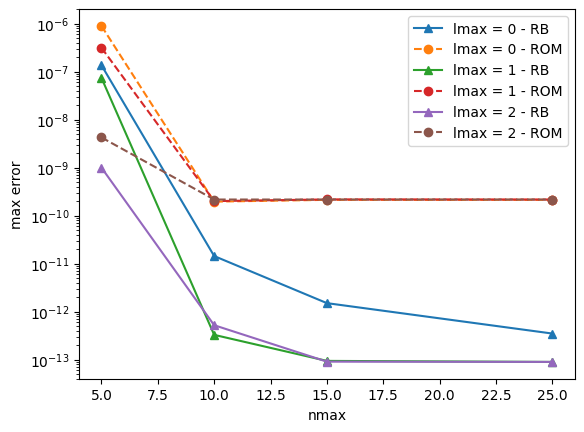

In [32]:
range_lmax = range(0,3)
range_nmax = [5,10,15,25]

plt.yscale("log")
plt.xlabel("nmax")
plt.ylabel("max error")

for lmax in range_lmax:
    max_errors_rb = []
    max_errors_eim = []
    max_errors_rom = []

    for nmax in range_nmax:
        rom = Surrogate(lmax = lmax,
                        nmax = nmax,
                        greedy_tol = 1e-16,
                        normalize = False
                       )
        rom.fit(training_set = ts_train,
                      parameters = q_train[:,0],
                      physical_points = times
               )

        errors_rb = []
        errors_eim = []
        errors_rom = []      
        for h, q in zip(ts_test, q_test):
            # calculamos la proyección de las ondas con el modelo hp-greedy
            h_rb = rom.base.transform(h,q[0])
            h_eim = rom.eim.transform(h,q[0])
            h_rom = rom.predict(q[0])

            # calculamos el error para la proyección
            errors_rb.append(error(h, h_rb, times))
            errors_eim.append(error(h, h_eim, times))
            errors_rom.append(error(h, h_rom, times))

        # tomamos el error máximo en el conjunto de validación
        max_errors_rb.append(np.max(errors_rb))
        max_errors_eim.append(np.max(errors_eim))
        max_errors_rom.append(np.max(errors_rom))

    plt.plot(range_nmax, max_errors_rb, "^-", label = f"lmax = {lmax} - RB")
    #plt.plot(range_nmax, max_errors_eim, "o-", label = f"lmax = {lmax} - EIM")
    plt.plot(range_nmax, max_errors_rom, "o--", label = f"lmax = {lmax} - ROM")

plt.legend();